In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('counts raw chondrosarcoma.xlsx', sheet='TargetCountMatrix') %>%
    filter(!str_detect(`TargetName`, '^TR[ABDG][JVC][0-9]*'))

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFC3,1.245731,1.741101,1.319508,1.148698,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.000000,1,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1,1.319508,1,1,1.000000,⋯,1.148698,2.605171,1.643752,1,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1,1.245731,1,1,1.000000,⋯,1.319508,4.324246,1.148698,1,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.430969,1,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1,1.000000,1,1,1.148698,⋯,1.430969,4.042823,1.148698,1,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1,1.000000,1,1,1.000000,⋯,1.245731,3.758480,1.000000,1,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

exp_tbl %>%
    head()

gene_symbol,sample_desc,sample_name,region_id,region_type,marker,norm_exp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
RFC3,NMS23-471 | 001 | S100B,NMS23-471,001,tumor,S100B,1.245731
RFC3,NMS23-471 | 002 | S100B,NMS23-471,002,tumor,S100B,1.741101
RFC3,NMS23-471 | 003 | S100B,NMS23-471,003,tumor,S100B,1.319508
RFC3,NMS23-471 | 004 | S100B,NMS23-471,004,tumor,S100B,1.148698
RFC3,NMS23-471 | 005 | CD68,NMS23-471,005,peritumor,CD68,1.000000
RFC3,NMS23-471 | 005 | CD3,NMS23-471,005,peritumor,CD3,1.000000


In [6]:
samples_of_interest <-
    sample_annotations

samples_of_interest

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor
NMS23-471 | 006 | CD68,NMS23-471,006,CD68,peritumor
NMS23-471 | 006 | CD3,NMS23-471,006,CD3,peritumor
NMS23-471 | 007 | CD68,NMS23-471,007,CD68,peritumor


In [7]:
exp_matrix_dge <-
    exp_matrix %>%
    select(-`TargetName`) %>%
    select(all_of(samples_of_interest$`sample_desc`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix %>% select(`TargetName`) %>% pull
        
        x
    }) 

exp_matrix_dge

,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,NMS23-471 | 007 | CD3,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
RFC3,1.245731,1.741101,1.319508,1.148698,1.000000,1.000000,1.000000,1.000000,1.000000,1.148698,⋯,1.000000,2.701920,1.000000,1.000000,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1.000000,1.319508,1.000000,1.000000,1.000000,1.515717,⋯,1.148698,2.605171,1.643752,1.000000,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1.000000,1.245731,1.000000,1.000000,1.000000,1.430969,⋯,1.319508,4.324246,1.148698,1.000000,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.515717,⋯,1.000000,2.701920,1.430969,1.000000,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1.000000,1.000000,1.000000,1.000000,1.148698,1.319508,⋯,1.430969,4.042823,1.148698,1.000000,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1.000000,1.000000,1.000000,1.000000,1.000000,1.319508,⋯,1.245731,3.758480,1.000000,1.000000,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731
APOB,1.000000,1.430969,2.141127,1.000000,1.000000,1.148698,1.000000,1.000000,1.000000,1.148698,⋯,1.000000,4.919019,1.319508,1.000000,1.741101,1.000000,1.319508,1.245731,1.000000,1.319508
RASGRP2,1.782602,1.000000,1.643752,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.245731,⋯,1.000000,4.816449,1.245731,1.000000,1.888175,1.430969,1.148698,1.000000,1.245731,1.430969
JAK2,1.551846,1.148698,1.515717,1.551846,1.000000,1.000000,1.000000,1.148698,1.000000,1.515717,⋯,1.319508,5.552989,1.245731,1.245731,1.319508,1.551846,1.000000,1.148698,1.000000,1.515717
PLA2G4E,1.000000,1.000000,1.000000,1.245731,1.000000,1.000000,1.000000,1.000000,1.000000,1.319508,⋯,1.245731,3.365865,1.148698,1.000000,1.974350,1.000000,1.148698,1.000000,1.148698,1.515717


In [8]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~`region_type`)

exp_model

,(Intercept),region_typetumor
1,1,1
2,1,1
3,1,1
4,1,1
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0
10,1,0


In [9]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [10]:
all_table <-
    topTable(all_fit, adjust.method='fdr', n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL2A1,0.6662905,9.605272,7.875441,6.386270e-13,1.159747e-09,18.85693216
COL11A2,0.3798275,9.567516,6.072872,9.904878e-09,8.993630e-06,9.67740975
FANCE,-0.2342073,9.488462,-5.288179,4.301351e-07,1.847700e-04,6.13368108
CUL1,0.2358876,9.532145,5.276003,4.549171e-07,1.847700e-04,6.09031011
HSD17B8,0.2246006,9.566479,5.251648,5.087281e-07,1.847700e-04,5.98586075
NDUFA13,0.2979779,9.634239,5.107628,9.788007e-07,2.962503e-04,5.36950326
PBX1,-0.2238218,9.484647,-5.031812,1.374930e-06,3.566960e-04,5.06062967
ILF3,0.1952583,9.504079,4.939357,2.071689e-06,4.314726e-04,4.67933511
MAPK11,-0.2067001,9.538956,-4.932167,2.138355e-06,4.314726e-04,4.65271252


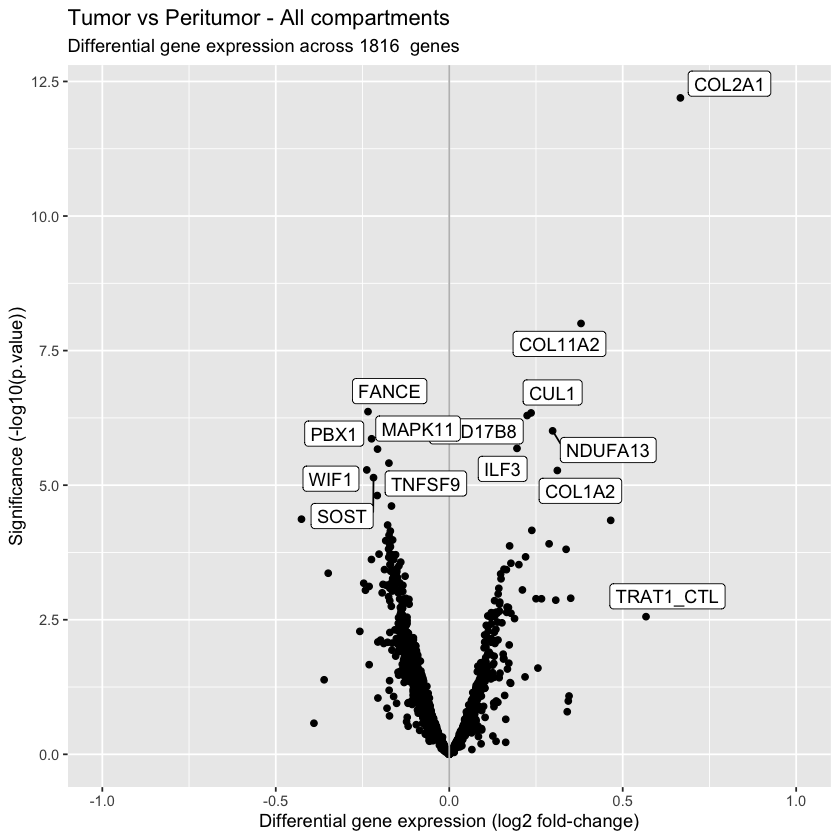

In [11]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 0.5 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 5 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-1, 1)


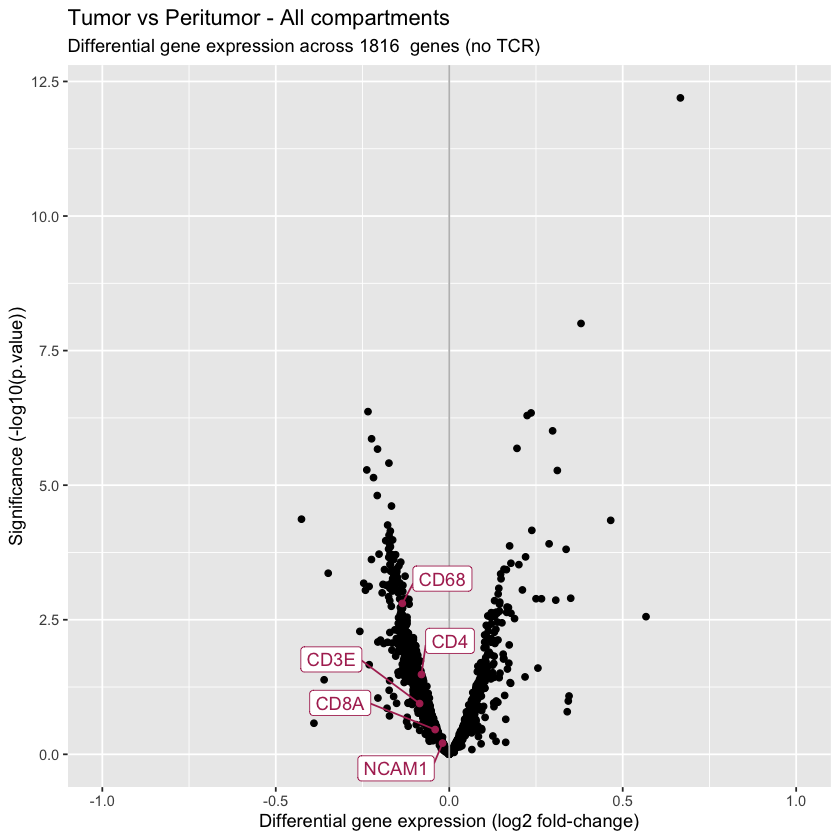

In [12]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('CD8A', 'CD4', 'CD3E', 'CD68', 'NCAM1') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-1, 1)


In [13]:
all_table %>%
    write_csv('geomx-dge-tumor_vs_peritumor-without_tcrs.csv')

In [14]:
all_table %>%
    filter(`adj.P.Val` < 0.05)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL2A1,0.6662905,9.605272,7.875441,6.386270e-13,1.159747e-09,18.8569322
COL11A2,0.3798275,9.567516,6.072872,9.904878e-09,8.993630e-06,9.6774098
FANCE,-0.2342073,9.488462,-5.288179,4.301351e-07,1.847700e-04,6.1336811
CUL1,0.2358876,9.532145,5.276003,4.549171e-07,1.847700e-04,6.0903101
HSD17B8,0.2246006,9.566479,5.251648,5.087281e-07,1.847700e-04,5.9858607
NDUFA13,0.2979779,9.634239,5.107628,9.788007e-07,2.962503e-04,5.3695033
PBX1,-0.2238218,9.484647,-5.031812,1.374930e-06,3.566960e-04,5.0606297
ILF3,0.1952583,9.504079,4.939357,2.071689e-06,4.314726e-04,4.6793351
MAPK11,-0.2067001,9.538956,-4.932167,2.138355e-06,4.314726e-04,4.6527125
